In [1]:
using CairoMakie
using TimerOutputs

include("../../src/Mesh.jl")
include("../../src/Sources.jl")
include("../../src/Matrix.jl")
include("../../src/Visualization.jl")

plot_mesh (generic function with 1 method)

In [2]:
ε = 8.854e-12
μ = 4e-7 * π
c = 1 / √(μ * ε)

2.9979563769321626e8

In [3]:
# Generate mesh
Nel = 35
l = (c / 144e6) * 0.479
a = 1e-3

nodes, edges = mesh_segment([-l / 2 0 0], [l / 2 0 0], Nel, 1)
end_points = get_end_points(nodes, edges)
basis_vecs = assign_basis_vector(nodes, edges)

msh = Mesh(nodes, edges, end_points, basis_vecs, a)

Mesh([-0.4986184390800368 0.0 0.0; -0.47012595684689185 0.0 0.0; … ; 0.47012595684689185 0.0 0.0; 0.4986184390800368 0.0 0.0], [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]  …  [26, 27], [27, 28], [28, 29], [29, 30], [30, 31], [31, 32], [32, 33], [33, 34], [34, 35], [35, 36]], [1, 36], [-1.0 0.0 0.0; -1.0 0.0 0.0; … ; -1.0 0.0 0.0; -1.0 0.0 0.0], 0.001)

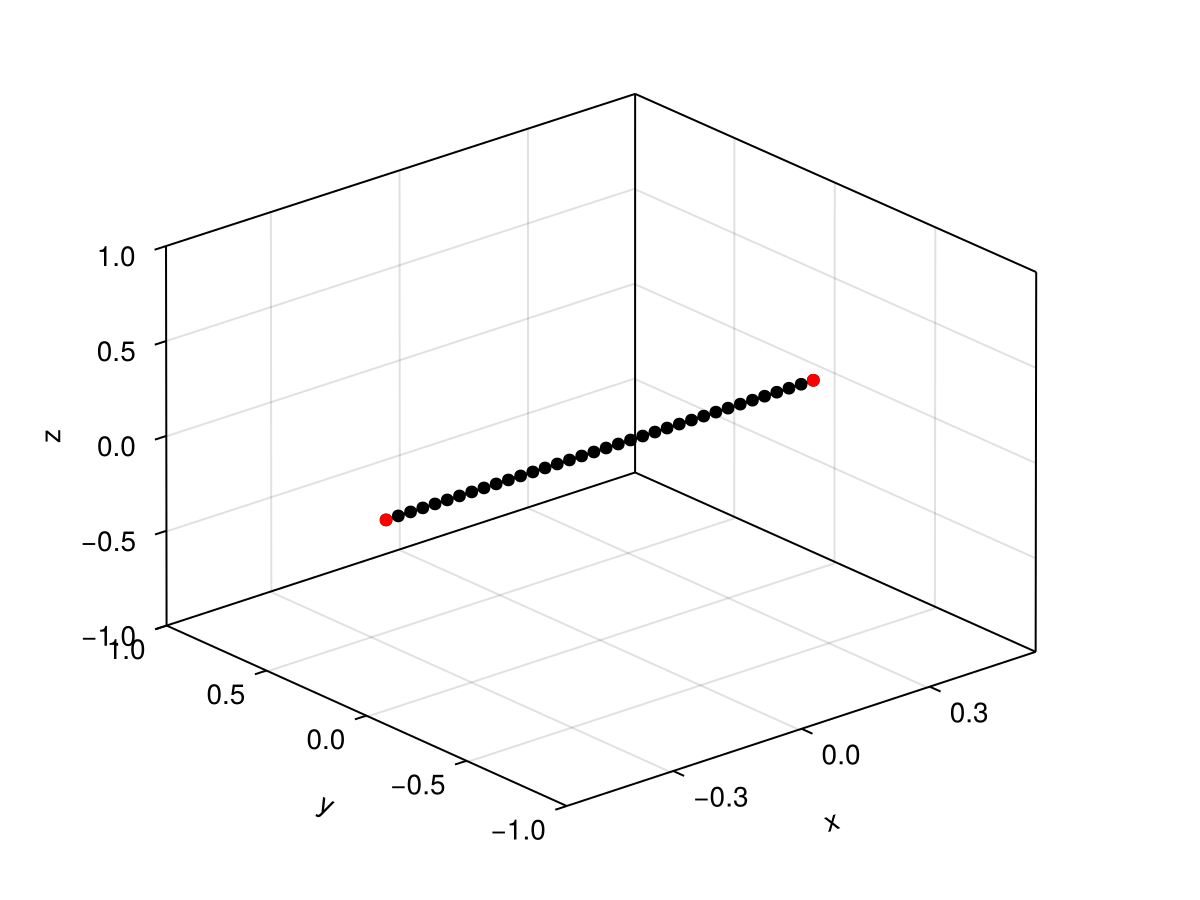

In [4]:
# Plot the antenna in 3D
f_msh = plot_mesh(msh)
f_msh

# Sources

In [5]:
# Mid-point feed
Vin = 1
idx_mid = Integer(ceil(Nel / 2))
src1 = VoltageSource(Vin, idx_mid)

src = [src1]

1-element Vector{VoltageSource}:
 VoltageSource(1, 18)

# Current distribution

In [10]:
reset_timer!()

# Assemble system equations
@timeit "assemble" Z, V = assemble_global(msh, src, 144e6, μ, ε)

# Solve system
@timeit "solve" Isol = Z \ V

print_timer()

e = msh.edges[src[1].edge]
Iin = sum(Isol[e]) / length(Isol[e])
Zin = Vin / Iin

─────────────────────────────────────────────────────────────────────────
                                Time                    Allocations      
                       ───────────────────────   ────────────────────────
   Tot / % measured:        144ms /  93.1%           31.3MiB /  99.9%    

Section        ncalls     time    %tot     avg     alloc    %tot      avg
─────────────────────────────────────────────────────────────────────────
assemble            1    134ms  100.0%   134ms   31.3MiB   99.9%  31.3MiB
  outer loop        1    134ms   99.9%   134ms   31.3MiB   99.9%  31.3MiB
    element     1.23k    122ms   90.7%  99.5μs   29.6MiB   94.6%  24.7KiB
solve               1   41.2μs    0.0%  41.2μs   21.6KiB    0.1%  21.6KiB
─────────────────────────────────────────────────────────────────────────


71.90833200881792 + 0.20500766924736735im

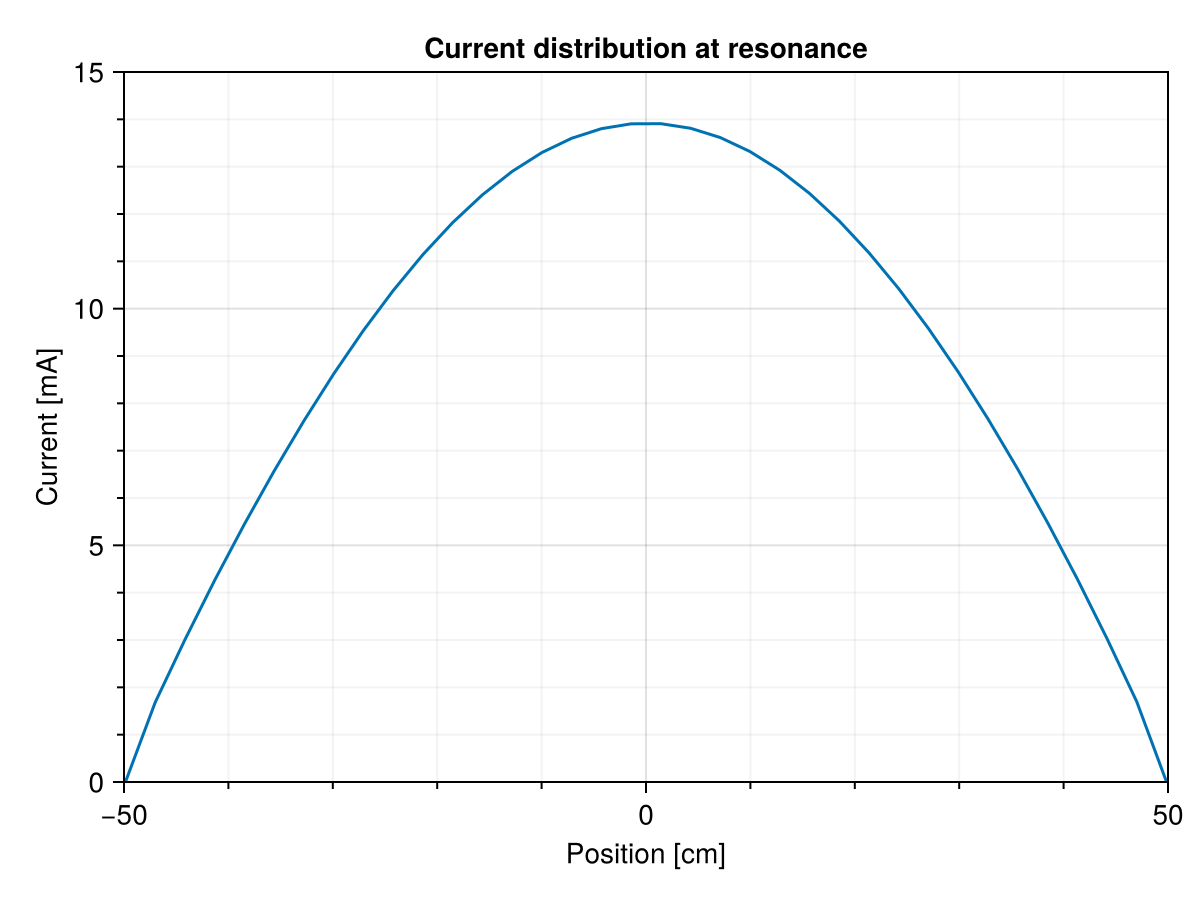

In [7]:
f = Figure()
ax = Axis(
    f[1, 1],
    xlabel="Position [cm]", ylabel="Current [mA]", title="Current distribution at resonance",
    limits=(-50, 50, 0, 15),
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5),
    yminorticksvisible=true, yminorgridvisible=true, yminorticks=IntervalsBetween(5),
)

lines!(ax, msh.nodes[:, 1] * 1e2, abs.(Isol) * 1e3)

f

# Frequency sweep

In [8]:
# Input impedance frequency sweep
frequencies = range(50e6, 300e6, 50)
Zin = zeros(Complex{Float64}, length(frequencies))

reset_timer!()

@timeit "frequency sweep" for (i, f) ∈ enumerate(frequencies)
    # Assemble system equations
    @timeit "assembly" Z, V = assemble_global(msh, src, f, μ, ε)

    # Solve system
    @timeit "solve" Isol = Z \ V

    e = msh.edges[src[1].edge]
    Iin = sum(Isol[e]) / length(Isol[e])
    Zin[i] = Vin / Iin
end

print_timer()

────────────────────────────────────────────────────────────────────────────
                                   Time                    Allocations      
                          ───────────────────────   ────────────────────────
    Tot / % measured:          1.69s /  94.1%           1.53GiB /  99.9%    

Section           ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────
frequency sweep        1    1.60s  100.0%   1.60s   1.53GiB  100.0%  1.53GiB
  assembly            50    1.57s   98.2%  31.3ms   1.53GiB   99.9%  31.3MiB
    outer loop        50    1.56s   98.1%  31.3ms   1.53GiB   99.9%  31.3MiB
      element      61.2k    1.46s   91.4%  23.8μs   1.45GiB   94.6%  24.7KiB
  solve               50   2.04ms    0.1%  40.9μs   1.04MiB    0.1%  21.3KiB
────────────────────────────────────────────────────────────────────────────


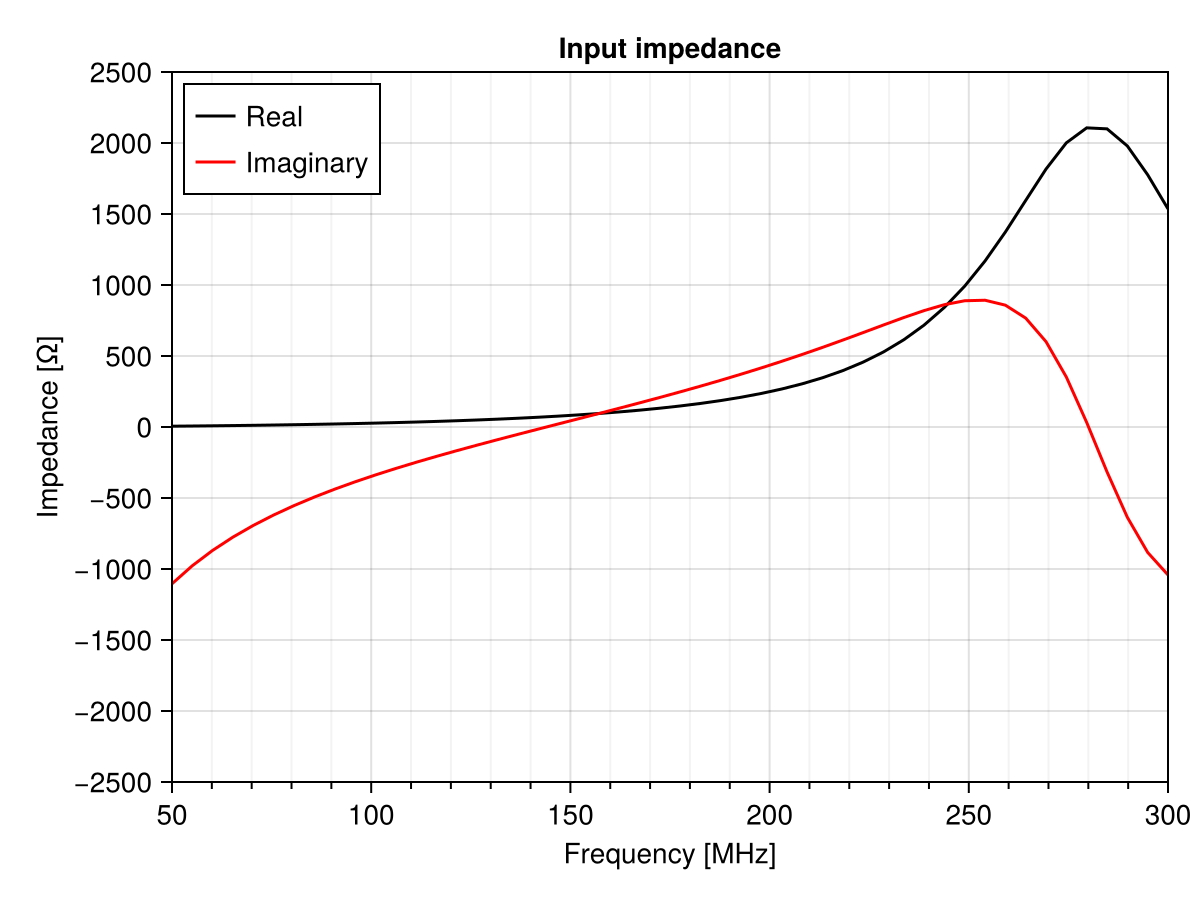

In [9]:
f = Figure()
ax = Axis(
    f[1, 1],
    xlabel="Frequency [MHz]", ylabel="Impedance [Ω]", title="Input impedance",
    limits=(50, 300, -2500, 2500),
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5),
    yticks=-2500:500:2500
)

lines!(ax, frequencies * 1e-6, real.(Zin), color=:black, label="Real")
lines!(ax, frequencies * 1e-6, imag.(Zin), color=:red, label="Imaginary")
axislegend(position = :lt)

f